# Import Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Import dataframe, drop following day measured rainfall, rename cols
df = pd.read_csv('ausraindata.csv')
df = df.rename({'MinTemp':'TempLow', 'MaxTemp':'TempHigh'}, axis=1)
df = df.drop('RISK_MM', axis=1)
df.shape

(142193, 23)

In [3]:
df.keys()

Index(['Date', 'Location', 'TempLow', 'TempHigh', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

# Feature Creation

In [4]:
# Feature to turn yes and no values into 1 and 0 values
def trans_bools(df, col):
    df[col] = np.where(df[col]=='Yes', 1, 0)
    return df

# Apply Features

In [5]:
# Function to apply all features to data
def apply_features(df):
    for col in ['RainToday', 'RainTomorrow']:
        df = trans_bools(df, col)
    return df

df = apply_features(df)

# Fill NA Values

In [6]:
# Number of null values per column
df.isnull().sum()

Date                 0
Location             0
TempLow            637
TempHigh           322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday            0
RainTomorrow         0
dtype: int64

In [7]:
# Fill categorical NA values with the value from previous day
df['WindGustDir'].fillna(method = 'bfill', inplace=True)
df['WindDir9am'].fillna(method = 'bfill', inplace=True)
df['WindDir3pm'].fillna(method = 'bfill', inplace=True)
df['RainToday'].fillna(method = 'bfill', inplace=True)

In [8]:
# Fill continuous NA values with the median value
continuous_cols = ['TempLow', 'TempHigh', 'Rainfall', 'Evaporation', 'Sunshine',
                   'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                   'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
                   'Cloud3pm', 'Temp9am', 'Temp3pm']

for col in continuous_cols:
    col_median = df[col].median()
    df[col].fillna(col_median, inplace=True)

# EDA

In [19]:
len(df['Date'].unique())

3436

In [9]:
df.head()

,Date,Location,TempLow,TempHigh,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,4.8,8.5,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,0,0
1,2008-12-02,Albury,7.4,25.1,0.0,4.8,8.5,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,0,0
2,2008-12-03,Albury,12.9,25.7,0.0,4.8,8.5,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,0,0
3,2008-12-04,Albury,9.2,28.0,0.0,4.8,8.5,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,0,0
4,2008-12-05,Albury,17.5,32.3,1.0,4.8,8.5,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0


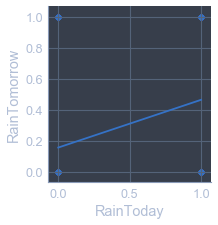

In [14]:
sns.pairplot(data=df, x_vars='RainToday', y_vars='RainTomorrow', kind='reg', height=3)
plt.show()

In [20]:
# features = df.drop('RainTomorrow', axis=1).keys()
# pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
# for row in pp_rows:
#     pp = sns.pairplot(data=df, x_vars=row, y_vars='RainTomorrow', kind='reg', height=3)
# plt.show()

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

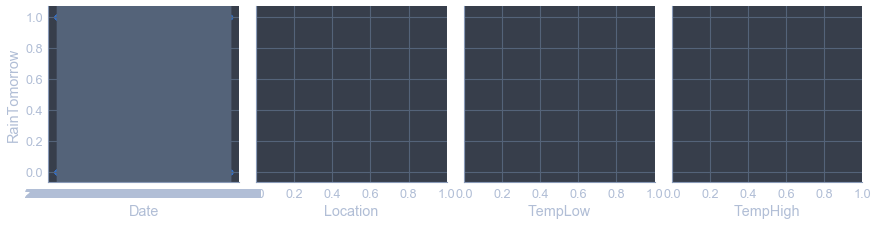

In [15]:
# Function to plot each feature vs target variable
def pplot_features(df, features):
    pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
    for row in pp_rows:
        pp = sns.pairplot(data=df, x_vars=row, y_vars='RainTomorrow', kind='reg', height=3)
    return plt.show()

pplot_features(df, df.drop('RainTomorrow', axis=1).keys())

In [15]:
df['RainTomorrow']

0         0
1         0
2         0
3         0
4         0
         ..
142188    0
142189    0
142190    0
142191    0
142192    0
Name: RainTomorrow, Length: 142193, dtype: int64

In [16]:
df.drop('RainTomorrow', axis=1).keys()

Index(['Date', 'Location', 'TempLow', 'TempHigh', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday'],
      dtype='object')